# Spike Report
## Introduction
In this tutorial we cover how to inspect a spike report using BlueBrain SNAP and access its properties.

We start by importing the `bluepysnap` package:

In [1]:
import bluepysnap

## Loading
In order to load the simulation data, we need the path to the file.

In [2]:
simulation_path = "/gpfs/bbp.cscs.ch/project/proj12/NSE/bluepysnap-functional-tests/simulation_config_bluepy_examples.json"
simulation = bluepysnap.Simulation(simulation_path)

Accessing simulation spike report is straightforward

In [3]:
spikes = simulation.spikes

## Timing

As with the `Simulation` instance, it's easy to access report start and end time, as well as the time step (dt)

In [4]:
print(
    spikes.time_start, 
    spikes.time_stop, 
    spikes.dt
)

0 1000.0 0.025


## Populations
If we are interested in the populations in spike report, they can be shown with

In [5]:
spikes.population_names

['hippocampus_neurons']

And when we know the population name, accessing it in the report is done as in the case of node/edge populations

In [6]:
spike_pop = spikes['hippocampus_neurons']
print(type(spike_pop))

<class 'bluepysnap.spike_report.PopulationSpikeReport'>


If we want to access the actual NodePopulation instance from the report, it can also be done

In [7]:
node_population = spike_pop.nodes
print(f'{node_population.name}: {type(node_population)}')

hippocampus_neurons: <class 'bluepysnap.nodes.node_population.NodePopulation'>


## Node IDs
Now that we are familiar with the basics, accessing the node_ids in the report and getting their info is as easy as

In [8]:
ids = spike_pop.node_ids
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

,layer,synapse_class,x,y,z
145,SP,EXC,475.613040,214.946340,418.594196
277,SP,EXC,102.885407,205.698670,820.509814
427,SP,EXC,151.772716,170.433333,808.895026
602,SP,EXC,175.807845,215.114387,620.637111
669,SP,EXC,569.932009,173.500045,760.627625


## Filtering
We can filter the report to only access the data we are interested in

In [9]:
filtered = spikes.filter(group={'layer':'SP'}, t_start=1, t_stop=100)
filtered.report.head()

,ids,population
times,,
1.700,7447,hippocampus_neurons
2.150,1006,hippocampus_neurons
2.150,11119,hippocampus_neurons
2.150,11654,hippocampus_neurons
2.225,10574,hippocampus_neurons


## Plotting
We may also want to visualize data. Plotting raster plot of filtered spikes:

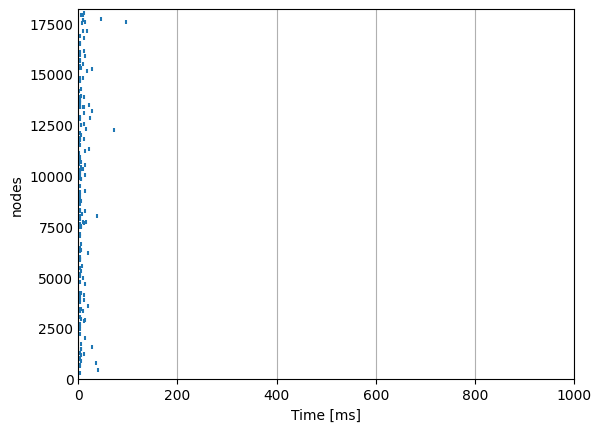

In [10]:
filtered.raster();

Plotting a firing rate histogram of the filtered spikes:

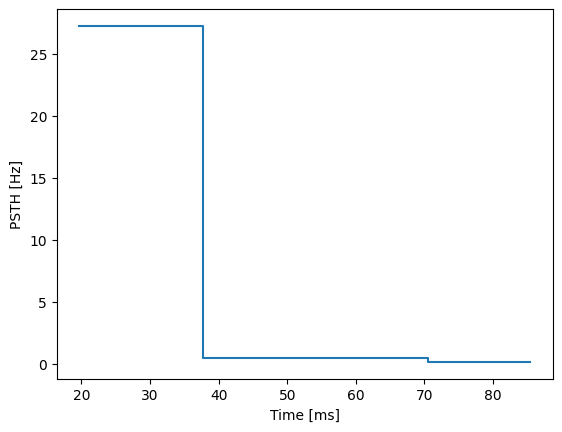

In [11]:
filtered.firing_rate_histogram();

The filtered report's `firing_rate_histogram` only takes into account the nodes that are present in the filtered report and thus the Y-axis frequency values do not represent the whole `group` the filtered report was created with.

Creating the same plot and computing frequencies based on the whole `group` can be done as follows:

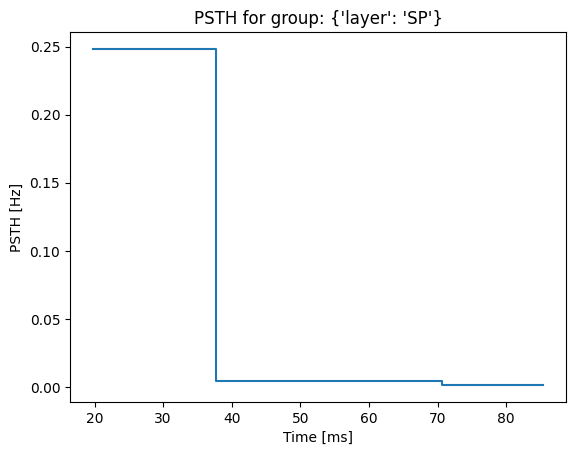

In [12]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()
ax.set_xlabel("Time [ms]")
ax.set_ylabel("PSTH [Hz]")
ax.set_title(f"PSTH for group: {filtered.group}")

times = filtered.report.index

time_start = np.min(times)
time_stop = np.max(times)

# heuristic for a nice bin size (~100 spikes per bin on average)
time_binsize = min(50.0, (time_stop - time_start) / ((len(times) / 100.0) + 1.0))

bins = np.append(np.arange(time_start, time_stop, time_binsize), time_stop)
hist, bin_edges = np.histogram(times, bins=bins)
node_count = len(simulation.circuit.nodes.ids(filtered.group))  # Get length of node ids for whole `group`
freq = 1.0 * hist / node_count / (0.001 * time_binsize)

# use the middle of the bins instead of the start of the bin
ax.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), freq, label="PSTH", drawstyle="steps-mid");

Only filtered reports have plotting cababilities. However, filters can be called without arguments which leads to the filtered object having all the available data

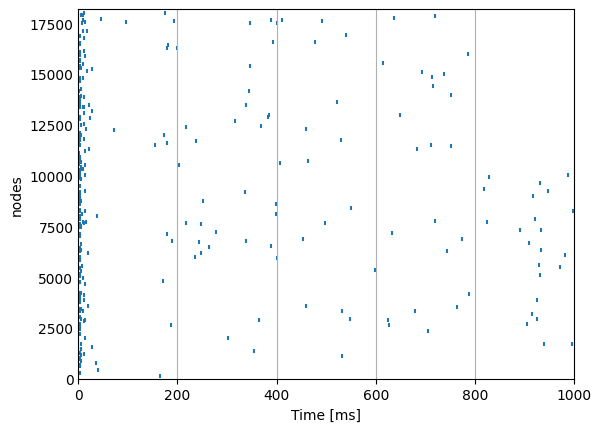

In [13]:
spikes.filter().raster();

It might also be useful to change the y-axis to e.g., m-type

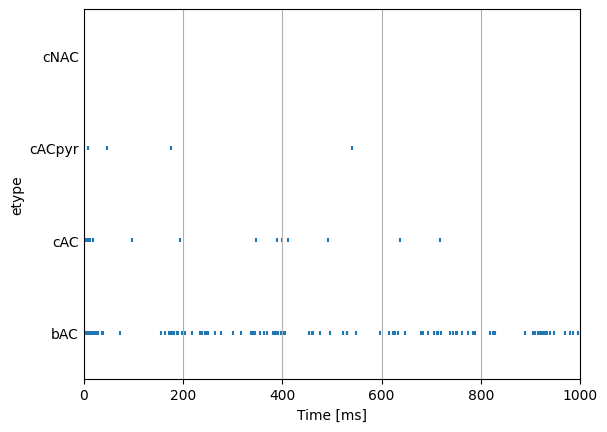

In [14]:
spikes.filter().raster(y_axis='etype');

One can also plot interspike interval plot

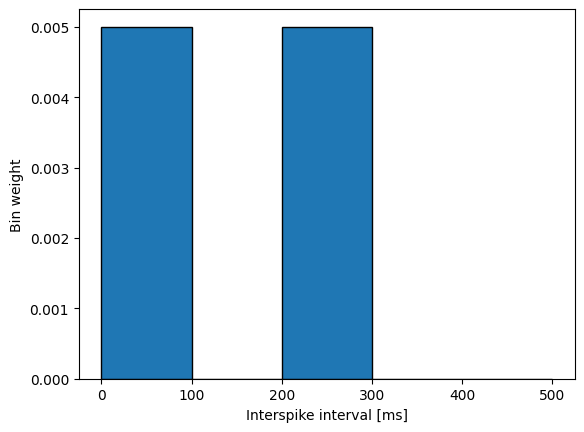

In [15]:
spikes.filter().isi(binsize=100);

## Reading the log
The `SpikeReport.log()` yields a file handler for the log file (raises error if log file not found). It can be read like any file in python:

In [16]:
with spikes.log() as l:
    print(" ...")
    print(*l.readlines()[20:30])
    print(" ...")

 ...
SimulatorMode set to 'CORENEURON'
 CoreNEURON requires Random123 generator, setting RNGMode = Random123
 [ INFO ] Using morphology path: /gpfs/bbp.cscs.ch/project/proj42/circuits/CA1.O1/mooc-circuit/morphologies/swc/
 [ INFO ] Running Neurodamus with config from BlueConfig
 [ STEP ] Loading Targets
 Reading target file /gpfs/bbp.cscs.ch/project/proj42/circuits/CA1.O1/mooc-circuit/start.target
 Reading target file /gpfs/bbp.cscs.ch/project/proj42/circuits/CA1.O1/mooc-circuit/user.target
   * Target AllCompartments  18198 cells [1 subtargets]
   * Target PV                 470 cells [3 subtargets]
   * Target CCK                231 cells [3 subtargets]

 ...


## Conclusion
We introduced how spike reports can be accessed and plotted with `bluepysnap`. Next we'll take a look into the frame reports.